## Setup

### Import libraries

In [69]:
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

### Import data

In [70]:
df = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')

## Exploration

In [71]:
df.shape

(20000, 21)

In [72]:
df.describe()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
count,2.000000e+04,20000.000000,20000.000000,20000.000000,2.000000e+04,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,2.000000e+04
mean,4.580297e+09,3.370200,2.115750,2079.883100,1.501533e+04,1.49645,0.007550,0.234900,3.409700,7.657700,1790.232900,289.650200,1971.100150,82.732150,98077.876850,47.559970,-122.213897,1986.387500,12748.96040,5.394367e+05
std,2.875295e+09,0.931931,0.770134,919.433672,3.970135e+04,0.54095,0.086564,0.767692,0.651895,1.175287,829.587101,441.537072,29.374008,397.872344,53.438026,0.138517,0.140649,685.211515,27076.48904,3.664334e+05
min,1.000102e+06,0.000000,0.000000,290.000000,5.200000e+02,1.00000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.00000,7.500000e+04
25%,2.123049e+09,3.000000,1.750000,1430.000000,5.040000e+03,1.00000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.750000,0.000000,98033.000000,47.470675,-122.328000,1490.000000,5100.00000,3.220000e+05
50%,3.904955e+09,3.000000,2.250000,1910.000000,7.620000e+03,1.50000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571450,-122.230000,1840.000000,7622.00000,4.500000e+05
75%,7.309825e+09,4.000000,2.500000,2550.000000,1.071000e+04,2.00000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98117.000000,47.678000,-122.124000,2360.000000,10088.25000,6.416250e+05
max,9.900000e+09,33.000000,8.000000,13540.000000,1.164794e+06,3.50000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.00000,7.700000e+06


In [73]:
df['date'].value_counts()

date
20140623T000000    135
20140626T000000    123
20140625T000000    120
20140708T000000    117
20150427T000000    116
                  ... 
20140727T000000      1
20150527T000000      1
20150524T000000      1
20140830T000000      1
20141115T000000      1
Name: count, Length: 370, dtype: int64

In [74]:
# graph average house price with waterfront is 1 vs 0

avg_price_by_waterfront = df.groupby('waterfront')['price'].median().reset_index()

fig = px.bar(avg_price_by_waterfront, x='waterfront', y='price',
             labels={'waterfront': 'Waterfront', 'price': 'Average Price'},
             title='Average House Price by Waterfront')

fig.show()


## Data cleaning

In [75]:
df["yr_sold"] = df["date"].str[0:4].to_numpy(np.int64)
df["mnth_sold"] = df["date"].str[4:6].to_numpy(np.int64)

df = df.drop(columns=['id'])
df = df.drop(columns=['date'])

# pd.to_datetime(df['date'])

## Create model

In [76]:
# Base, no cleaning of data or parameter testing.
X = pd.get_dummies(df.drop(["price"], axis=1))
y = df["price"]

model = XGBRegressor()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

X

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold,mnth_sold
0,4,3.25,3760,4675,2.0,0,0,3,8,2740,1020,2007,0,98038,47.3862,-122.048,3280,4033,2014,11
1,3,1.75,1460,7800,1.0,0,0,2,7,1040,420,1979,0,98023,47.3035,-122.382,1310,7865,2015,1
2,4,1.00,1340,5800,1.5,0,2,3,7,1340,0,1914,0,98116,47.5658,-122.389,1900,5800,2014,10
3,3,1.75,1440,8050,1.0,0,0,3,8,1440,0,1985,0,98023,47.3187,-122.390,1790,7488,2014,12
4,2,1.50,1780,4750,1.0,0,0,4,7,1080,700,1947,0,98117,47.6859,-122.395,1690,5962,2014,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,3,1.50,1000,6914,1.0,0,0,3,7,1000,0,1947,0,98125,47.7144,-122.319,1000,6947,2014,11
19996,3,2.50,3087,5002,2.0,0,0,3,8,3087,0,2014,0,98023,47.2974,-122.349,2927,5183,2014,11
19997,3,2.50,2120,4780,2.0,0,0,3,7,2120,0,2004,0,98053,47.6810,-122.032,1690,2650,2014,9
19998,1,0.75,380,15000,1.0,0,0,3,5,380,0,1963,0,98168,47.4810,-122.323,1170,15000,2014,6


### Model stats

In [77]:
sse = np.sum((y_test - y_pred) ** 2)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

display(sse)
display(mse)
display(rmse)
display(r2)

76498663590521.39

19124665897.63035

138291.95890445093

0.8731940514778838

## Evaluate Mini dataset

In [78]:
mini = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv")

### Do transformations

In [81]:
X = pd.get_dummies(mini.drop(["date"], axis=1))
X["yr_sold"] = mini["date"].str[0:4].to_numpy(np.int64)
X["mnth_sold"] = mini["date"].str[4:6].to_numpy(np.int64)
X = X.drop(columns=['id'])

### Generate predictions and csv

In [82]:
mini_pred = model.predict(X)
mini_pred = pd.DataFrame(mini_pred, columns=['price'])
mini_pred.to_csv("team2-predictions.csv", index=False)

### Feature importances

<Axes: >

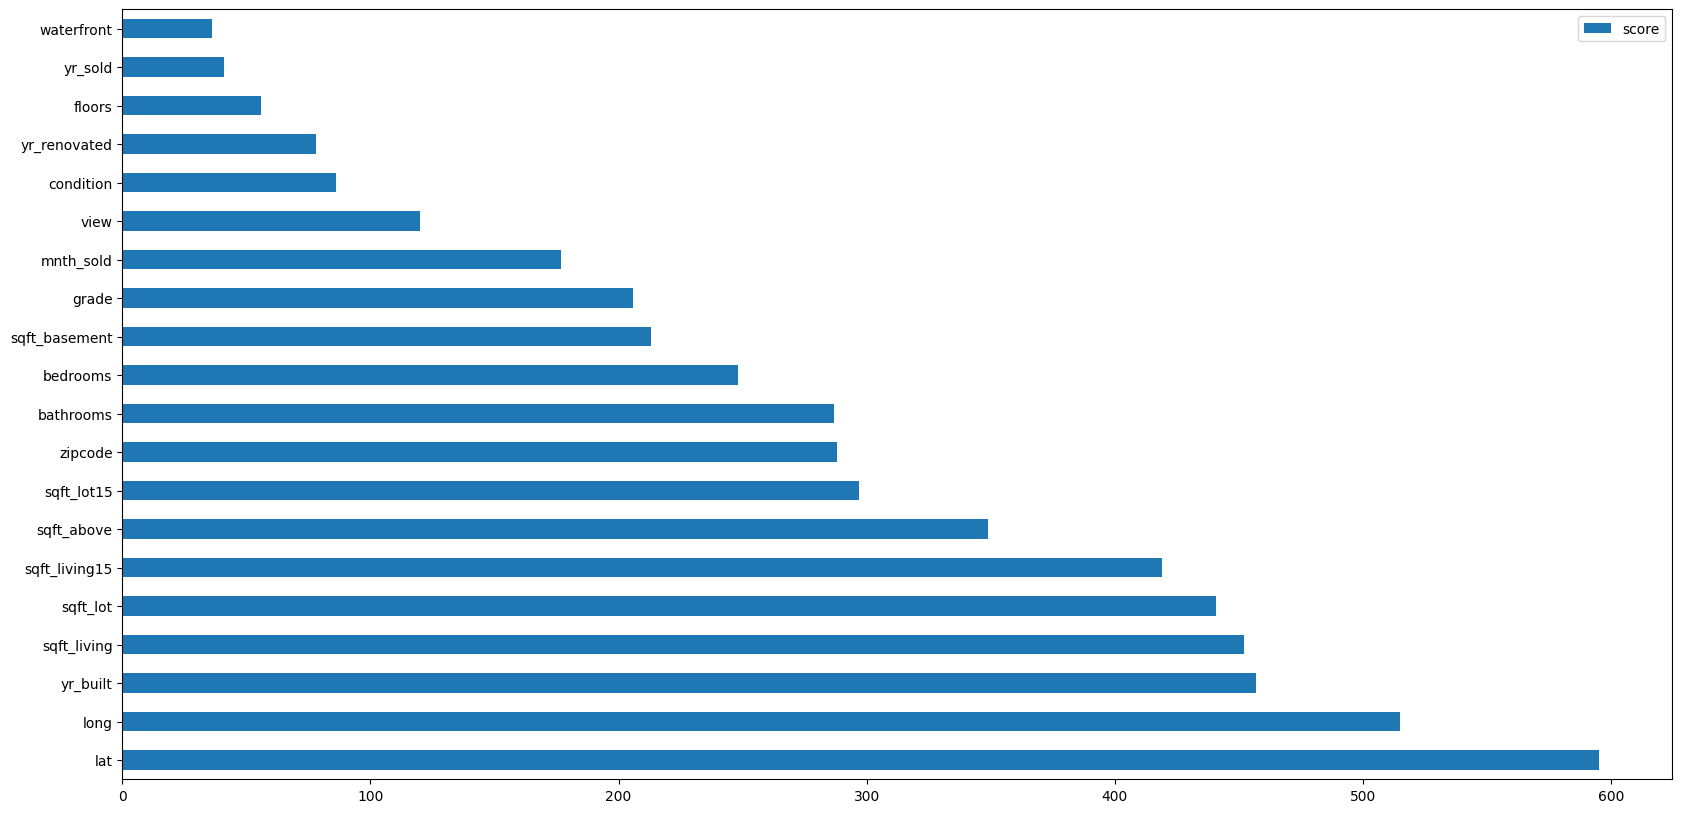

In [83]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features